# Introduction

Phase 2 Graded Challenge 7

Achmad Dhani

HCK-009

Objective: Mental health is important and a lot of people either doubt or confused regarding in what they are feeling. Validation helps as a reassurance for a lot of people, giving them affirmation by knowing that others shares those same feelings. Employing NLP machine learning with high accuracy will efficiently classify emotions in the hopes to make a person's day a brighter.


# Import Libraries

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
#preprocess
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
#visual
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
#models
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout, LSTM, TextVectorization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# etc
import warnings
from joblib import dump

2023-11-19 16:44:21.620023: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 16:44:21.951564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 16:44:22.981979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Functions

In [18]:
# add new stopwords part of preprocess_text
stop_words_en = stopwords.words('english')
new_stop_words = ['feel', 'feeling', 'like', 'im', 'get',
                  'really', 'time', 'know', 'id', 'ive', 'little',
                  'people', 'want', 'thing', 'make'
                  ]
stop_words_en = stop_words_en + new_stop_words
stop_words_en = list(set(stop_words_en))

# for preprocessing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower() # lowercase text
    tokens = word_tokenize(text) # tokenize
    filtered_words = [word for word in tokens if word.lower() not in stop_words_en]
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words]
    lemmatized_clean = [word.translate(str.maketrans('', '', string.punctuation)) for word in lemmatized_words]
    return ' '.join(lemmatized_clean)


# function for plotting result
def plot_result(result):
  result_df = pd.DataFrame(result.history)
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  sns.lineplot(data=result_df[['accuracy', 'val_accuracy']])
  plt.grid()
  plt.title('Accuracy vs Val-Accuracy')

  plt.subplot(1, 2, 2)
  sns.lineplot(data=result_df[['loss', 'val_loss']])
  plt.grid()
  plt.title('Loss vs Val-Loss')
  plt.show()

# function for evaluation report
def performance_check(model, X, y_ohe):
  display_labels =['fear', 'anger', 'joy']
  y_pred = model.predict(X)
  predictions = np.argmax(y_pred, axis=1)
  labels = np.argmax(y_ohe, axis=1)

  cm = confusion_matrix(labels, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  print(classification_report(labels, predictions, target_names=display_labels))


# Data loading

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/Emotion_classify_Data.csv')
data.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


The dataset consist of `5937` entries with `2` object colums

In [ ]:
# checking missing values
data.isna().sum()

Comment    0
Emotion    0
dtype: int64

In [ ]:
data.duplicated().sum()

0

The data is clean, there is no missing values and no duplicates

# EDA

In [ ]:
# checkpoint for eda
eda= data.copy()

## Basic Analysis

In [14]:
# basic summary analysis
emotion_counts = eda['Emotion'].value_counts()

eda['Comment Length'] = eda['Comment'].apply(len)
eda['Word Count'] = eda['Comment'].apply(lambda x: len(x.split()))

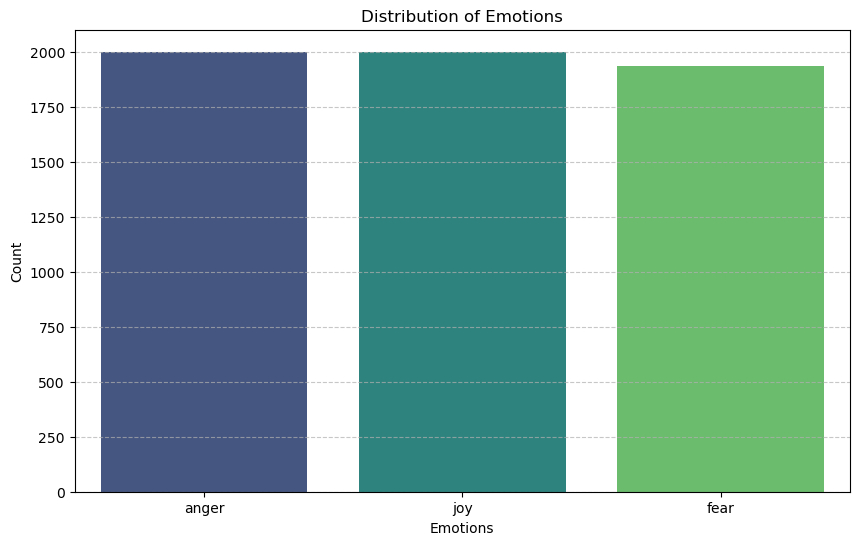

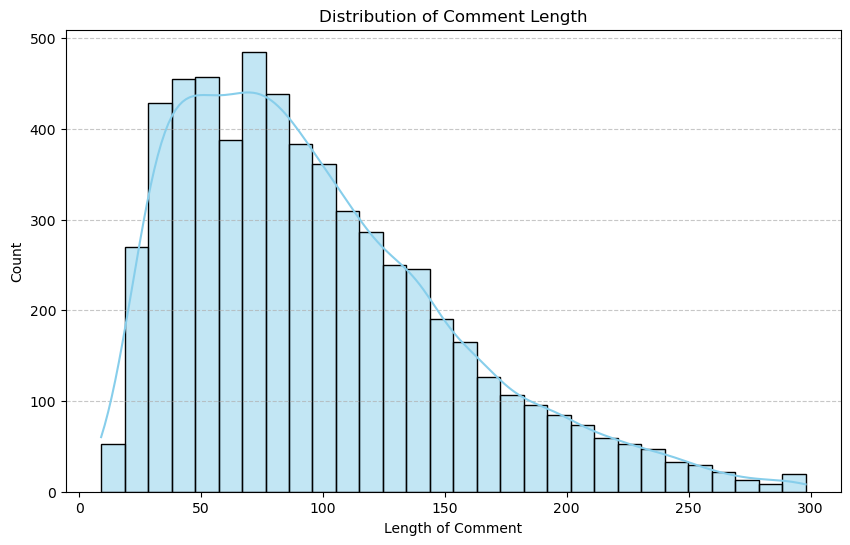

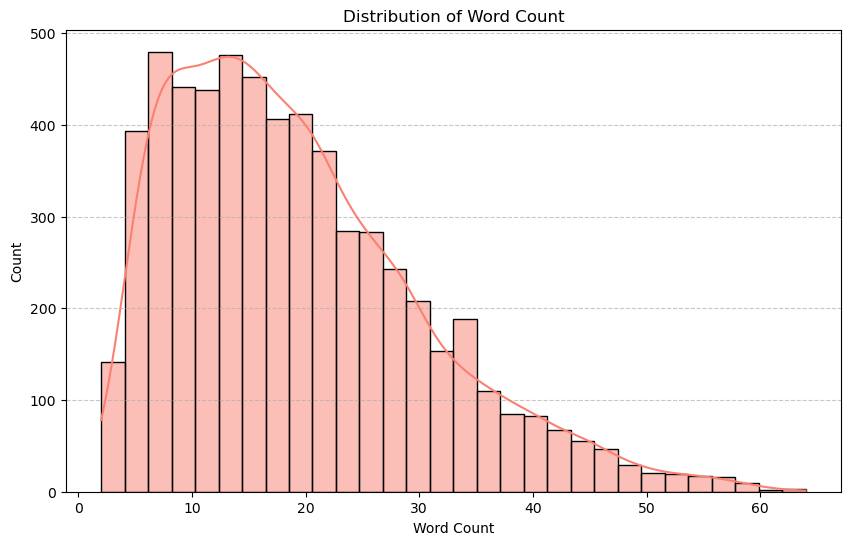

In [12]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# emotion distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, hue=emotion_counts.index, palette="viridis", legend=False)
plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# comment length distribution
plt.figure(figsize=(10, 6))
sns.histplot(eda['Comment Length'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Comment Length')
plt.xlabel('Length of Comment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(eda['Word Count'], bins=30, kde=True, color='salmon', edgecolor='black')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The visualization above shows:
- The dataset has a balance target class which are `anger, joy, and fear`
- The distribution of comment length skewed to the right with the majority of the data is within `30 to 130` comment length
- The outliers are the comment lengths that is above `244`
- The same goes to the word count, the distribution is skewed to the right with the majority of the data is within the range of `5 to 30` word count
- This gives insight about how expressive the people are in the dataset. Most people quite concise but there are a few who's very expressive and open about what they feel.

In [15]:
# saving for deployment
eda.to_csv('eda.csv', index= False)

## Text Preprocessing for EDA

In [ ]:
eda.sample(10)['Comment']

455                     i feel less bitchy in the morning
92      im not afraid of going on my own but i feel li...
719                             i feel a little bit weird
3752       i am feeling suspicious lj cut text suspicions
2636    i should be feeling eager to leap into stash o...
1350                          i feel completely shaken up
3857            ive been feeling weird because i am weird
266     i feel very distressed because i m supportive ...
888        i still feel somewhat dissatisfied with myself
3509    im not sure jeremy will be feeling quite so fr...
Name: Comment, dtype: object

In [ ]:
# calling function
eda['Processed Comment'] = eda['Comment'].apply(preprocess_text)

In [ ]:
eda[['Processed Comment', 'Emotion']].sample(10)

,Processed Comment,Emotion
3665,realised something wrong started everyone hate...,anger
4010,natasha gan dress co wear fab blue suede boot ...,joy
5693,frustrated tired today,anger
1149,pain pleasant,joy
5660,pissed justanswer,anger
444,drive home petty thief stolen exposure crudely...,anger
4395,honored,joy
2794,living lately often wife also ubuntu user bit ...,fear
5235,saying cut everyone life important find comfor...,joy
445,mad upset day scared,fear


To make things more efficient and effective, tokenization which is mostly done in feature engineering will be done in EDA as well

## Most Common Words of Each Emotions

In [ ]:
# using counter to count the number of words
words = [word for text in eda['Processed Comment'] for word in text.split()]

word_freq = Counter(words) # count of each word

In [ ]:
# respective emotions word count
emotion_word_freq= {}

for emote in eda['Emotion'].unique():
    words= [word for text in eda[eda['Emotion'] == emote]['Processed Comment'] for word in text.split()]
    emotion_word_freq[emote] = Counter(words)

### Joy

In [ ]:
# isolating joy
joy_word_freq= emotion_word_freq['joy']

print('Top 10 most frequent joy words')
display(joy_word_freq.most_common(10))
print()
print('Top 10 lest frequent joy words')
display(joy_word_freq.most_common()[:-n-1:-1])

Top 10 most frequent joy words


[('day', 91),
 ('life', 76),
 ('good', 76),
 ('something', 76),
 ('one', 76),
 ('going', 72),
 ('way', 72),
 ('even', 71),
 ('much', 69),
 ('think', 67)]


Top 10 lest frequent joy words


[('intimated', 1),
 ('urgh', 1),
 ('spontaneous', 1),
 ('sachaying', 1),
 ('handbag', 1),
 ('ambition', 1),
 ('stasia', 1),
 ('coz', 1),
 ('anger', 1),
 ('amazingly', 1)]

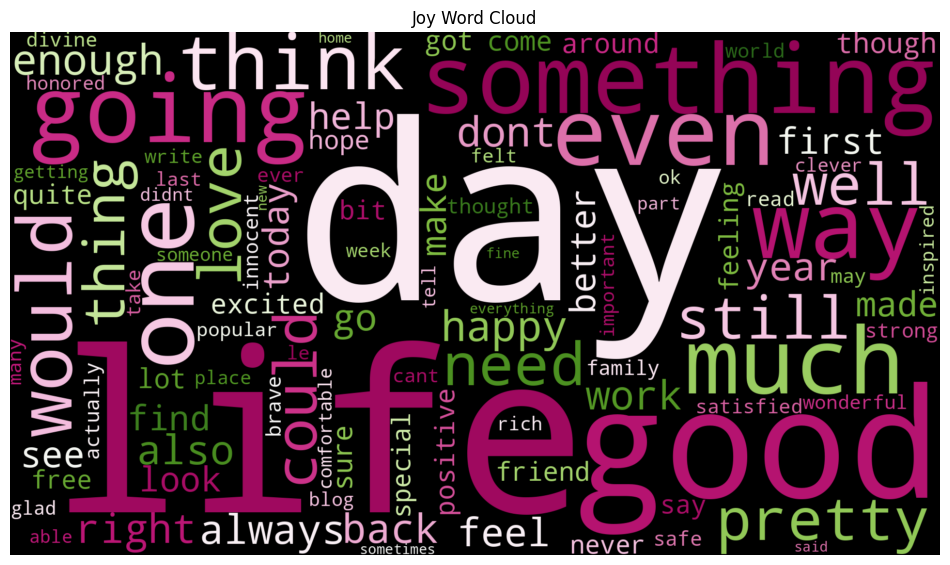

In [ ]:
joy_wordcloud = WordCloud(width=1920, height=1080,
                      max_words= 100,
                      background_color='black',
                      colormap='PiYG').generate_from_frequencies(joy_word_freq)

plt.figure(figsize=(12, 8))

# Display the word cloud
plt.imshow(joy_wordcloud, interpolation='bilinear')
plt.title('Joy Word Cloud')
plt.axis('off')
plt.savefig('joy_wordcloud.png')

plt.show()

The Joy wordcloud highlights commonly used words associated with feelings of joy, such as `life, good, day, something, going, and well`, indicating that these terms are often expressed when people describe joyful experiences.

### Anger

In [ ]:
# isolating anger emotion words
anger_word_freq= emotion_word_freq['anger']
print('Top 10 most frequent anger words')
display(anger_word_freq.most_common(10))
print()
print('Top 10 lest frequent anger words')
display(anger_word_freq.most_common()[:-n-1:-1])

Top 10 most frequent anger words


[('even', 87),
 ('way', 85),
 ('would', 84),
 ('one', 81),
 ('angry', 79),
 ('think', 74),
 ('thing', 73),
 ('day', 72),
 ('could', 72),
 ('bit', 70)]


Top 10 lest frequent anger words


[('center', 1),
 ('leading', 1),
 ('led', 1),
 ('cross', 1),
 ('binging', 1),
 ('stic', 1),
 ('confined', 1),
 ('bein', 1),
 ('runnin', 1),
 ('cola', 1)]

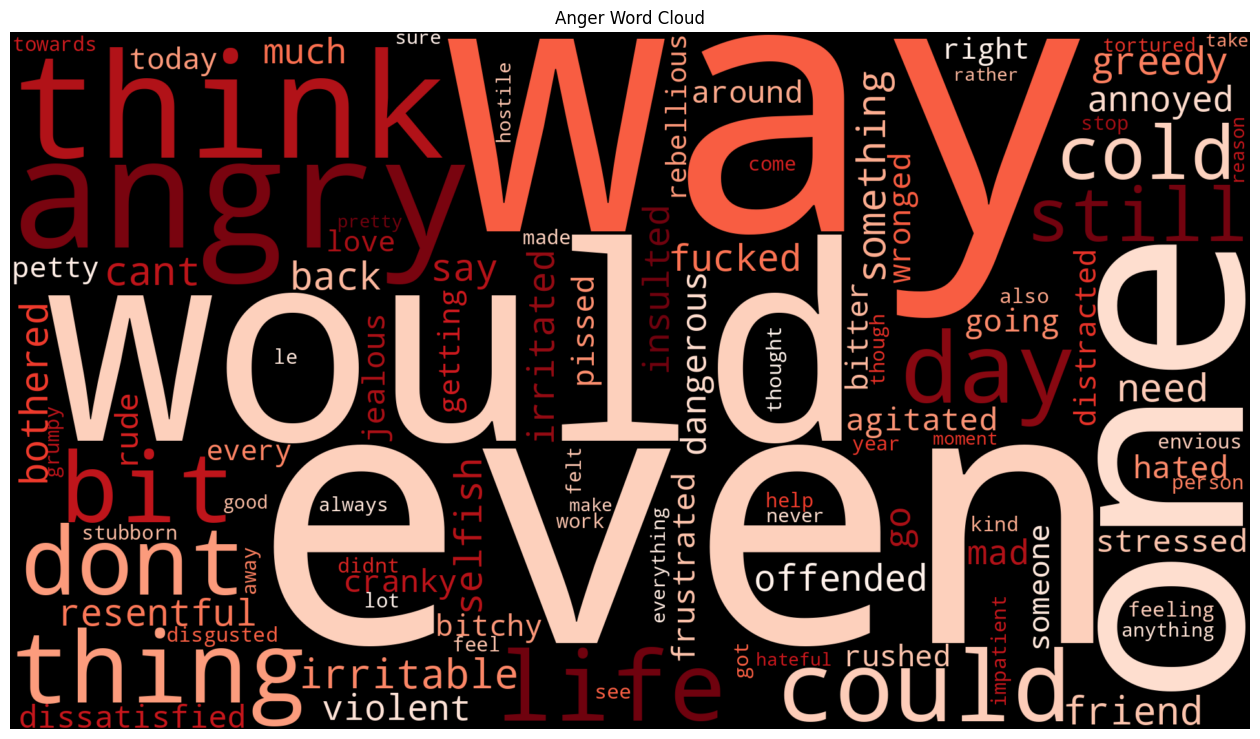

In [ ]:
anger_wordcloud = WordCloud(width=1920, height=1080,
                      max_words= 100,
                      background_color='black',
                      colormap='Reds').generate_from_frequencies(anger_word_freq)

plt.figure(figsize=(16, 10))

# display the word cloud
plt.imshow(anger_wordcloud, interpolation='bilinear')
plt.title('Anger Word Cloud')
plt.axis('off')
plt.savefig('anger_wordcloud.png')

plt.show()

The Anger wordcloud highlights commonly used words associated with feelings of anger, such as `would, even, way, think, angry`, indicating that these terms mostly expressed when people are angry. Anger is a special case where, words like would and even is an auxiliary verb, which indicates a mood or tense.

### Fear

In [ ]:
# isolating fear emotion words
fear_word_freq= emotion_word_freq['fear']
print('Top 10 most frequent fear words')
display(fear_word_freq.most_common(10))
print()
print('Top 10 lest frequent fear words')
display(fear_word_freq.most_common()[:-n-1:-1])

Top 10 most frequent fear words


[('bit', 118),
 ('still', 84),
 ('think', 79),
 ('strange', 78),
 ('nervous', 75),
 ('terrified', 74),
 ('going', 72),
 ('one', 71),
 ('would', 71),
 ('anxious', 71)]


Top 10 lest frequent fear words


[('planting', 1),
 ('clingy', 1),
 ('familiar', 1),
 ('account', 1),
 ('professional', 1),
 ('frequented', 1),
 ('website', 1),
 ('chase', 1),
 ('similarity', 1),
 ('lighten', 1)]

`'feel', 'feeling', 'like'` are added to the StopWord lists since these 3 words usages are very frequent and don't have any independent meaning

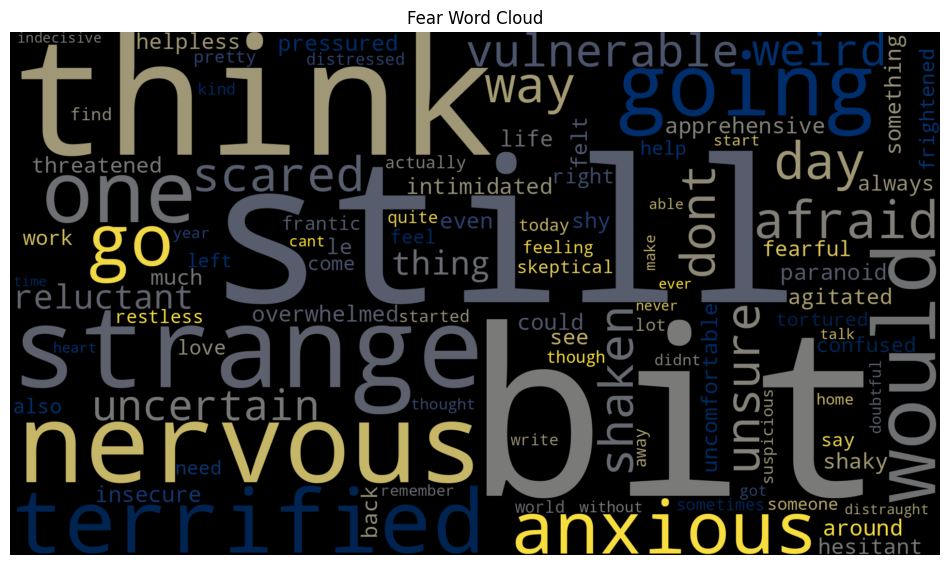

In [ ]:
fear_wordcloud = WordCloud(width=1920, height=1080,
                      max_words= 100,
                      background_color='black',
                      colormap='cividis').generate_from_frequencies(fear_word_freq)

plt.figure(figsize=(12, 8))

# display the word cloud
plt.imshow(fear_wordcloud, interpolation='bilinear')
plt.title('Fear Word Cloud')
plt.axis('off')
plt.savefig('fear_wordcloud.png')

plt.show()

The Fear wordcloud highlights commonly used words associated with feelings of fear, such as `still, bit, strange, think`, indicating that these terms are often expressed when people describing or more accurately worriness and anxiousness. This is justified since fear in the context of fear of the unknown is believe to cause worriness and anxiousness on a person. Fear is a broad emotion that can be more interpreted two ways, fear of the unknown that cause anxiety or being scared/teriffied and giving goosebumps

# Feature Engineering

In [ ]:
# dataframe for machine learning
df = data.copy()

## Text Processing for Model

In [ ]:
# calling function
df['preprocessed_text'] = df['Comment'].apply(preprocess_text)

In [ ]:
df.head()

,Comment,Emotion,preprocessed_text
0,i seriously hate one subject to death but now ...,fear,seriously hate one subject death reluctant drop
1,im so full of life i feel appalled,anger,full life appalled
2,i sit here to write i start to dig out my feel...,fear,sit write start dig feeling think afraid accep...
3,ive been really angry with r and i feel like a...,joy,angry r idiot trusting first place
4,i feel suspicious if there is no one outside l...,fear,suspicious one outside rapture happened something


Words will be the features in NLP. Reducing uncessary words leads to quicker model, and higher accuracy since the model can learn the pattern more with less noise

## Target Conversion

In [ ]:
# labelling the target
df['label'] = df['Emotion'].replace({'fear' : 0, 'anger' : 1, 'joy' : 2})

In [ ]:
df.head()

,Comment,Emotion,preprocessed_text,label
0,i seriously hate one subject to death but now ...,fear,seriously hate one subject death reluctant drop,0
1,im so full of life i feel appalled,anger,full life appalled,1
2,i sit here to write i start to dig out my feel...,fear,sit write start dig feeling think afraid accep...,0
3,ive been really angry with r and i feel like a...,joy,angry r idiot trusting first place,2
4,i feel suspicious if there is no one outside l...,fear,suspicious one outside rapture happened something,0


In [ ]:
# balance
df['label'].value_counts()

1    2000
2    2000
0    1937
Name: label, dtype: int64

## Data Splitting

In [ ]:
# data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.preprocessed_text,
                                                    df.label,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=df.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.125,
                                                  random_state=42,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (4155,)
Val Size   :  (594,)
Test Size  :  (1188,)


In [ ]:
# onehot encoder
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Machine learning can only learn from numeric data type. Multiclass target need to be converted with One hot encoder making it into a matrix.

# Model Building

## Vectorization

In [ ]:
# vectorization
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<4155x6508 sparse matrix of type '<class 'numpy.int64'>'
	with 30432 stored elements in Compressed Sparse Row format>

In [ ]:
# total vocab and verbs
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  6508
Maximum Sentence Length :  32 tokens


This indicates a sparse matrix with 4,155 rows and 6,508 columns. A sparse matrix is a matrix in which most of the elements are zero. Stored elements mean out of all hte possibility of the number of elements(4,155 x 6508),  30432 are non-zero.

The total vocab after tokenization is 6508 unique words with the longest sentece having 32 tokens (words)

In [ ]:
# text vectorize
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize=None,
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

text_vectorization.adapt(X_train)

In [ ]:
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In NLP, text vectorization is converting text data into numbers.

Text Vectorization is the process of converting text into numerical vectors by counting the frequency of each word in the text. The simplest form is the Bag-of-Words model, which creates a vocabulary of all unique words and assigns each word a unique number. Then, for each document or piece of text, it counts the number of times each word appears.

Word Embeddings is a type of word representation that allows words with similar meaning to have a similar representation. It is a distributed representation that is learned from the text and can capture contextual cues and semantic similarity. Embeddings capture more nuanced information and relationships between words.

## RNN

In [ ]:
# model
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
rnn_units = 64

model_rnn = Sequential()

model_rnn.add(text_vectorization)
model_rnn.add(embedding)
model_rnn.add(SimpleRNN(rnn_units))
model_rnn.add(Dense(units=3, activation='softmax'))

model_rnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           833024    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 845571 (3.23 MB)
Trainable params: 845571 (3.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- RNN is used since it's the fastest model
- Embeddings help a model understand these subtleties and get better at figuring out the emotion behind a piece of text hence it's necessary for emotion classification.
- Softmax activation is used since the target is a multiclass.

In [ ]:
model_rnn_hist = model_rnn.fit(
    X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe)
    )

Epoch 1/50
130/130 [==============================] - 19s 101ms/step - loss: 0.9563 - accuracy: 0.5254 - val_loss: 0.7617 - val_accuracy: 0.7054
Epoch 2/50
130/130 [==============================] - 6s 43ms/step - loss: 0.4661 - accuracy: 0.8380 - val_loss: 0.7100 - val_accuracy: 0.7727
Epoch 3/50
130/130 [==============================] - 8s 64ms/step - loss: 0.2163 - accuracy: 0.9336 - val_loss: 0.7878 - val_accuracy: 0.7542
Epoch 4/50
130/130 [==============================] - 5s 36ms/step - loss: 0.0925 - accuracy: 0.9757 - val_loss: 0.8726 - val_accuracy: 0.7626
Epoch 5/50
130/130 [==============================] - 6s 47ms/step - loss: 0.0563 - accuracy: 0.9839 - val_loss: 0.9264 - val_accuracy: 0.7441
Epoch 6/50
130/130 [==============================] - 6s 48ms/step - loss: 0.0511 - accuracy: 0.9865 - val_loss: 1.2691 - val_accuracy: 0.7357
Epoch 7/50
130/130 [==============================] - 5s 36ms/step - loss: 0.0573 - accuracy: 0.9846 - val_loss: 1.0048 - val_accuracy: 0.74

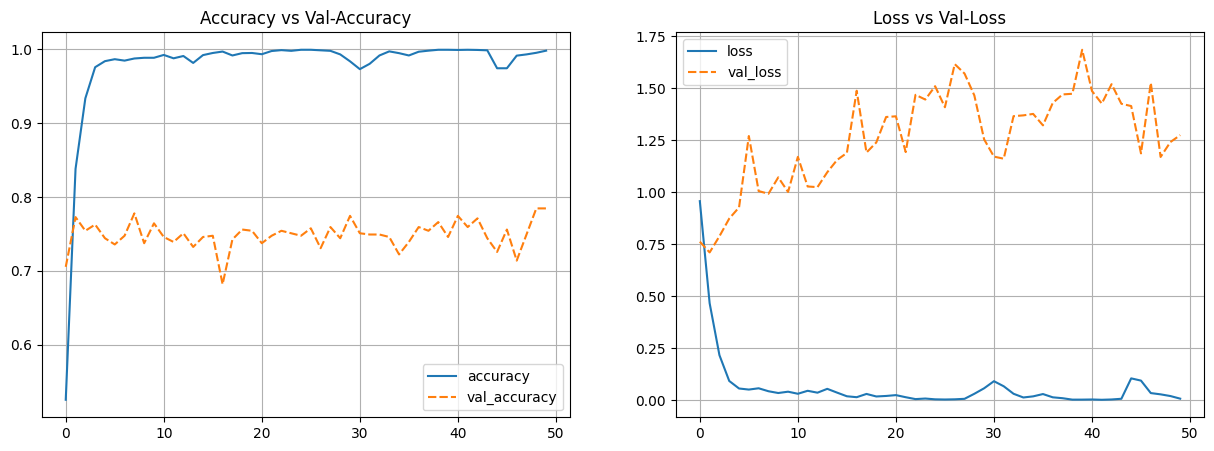

In [ ]:
# plot result

plot_result(model_rnn_hist)

This model overfits by a lot as seen on the graph

## Tuned Model 1

In [ ]:
# model tuned 1
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model_tuned = Sequential()

model_tuned.add(text_vectorization)
model_tuned.add(embedding)
model_tuned.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_tuned.add(Dropout(0.1))
model_tuned.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_tuned.add(Dropout(0.1))
model_tuned.add(Dense(3, activation='softmax'))


model_tuned.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           833024    
                                                                 
 bidirectional (Bidirection  (None, 32, 64)            41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                        

- LSTM is used instead of RNN for a more complex and to resolve vanishing or exploding gradients that RNN can cause
- Bidirectional processing allows the network to have information about the past and the future context at every point in the sequence, which can lead to more accurate prediction
- Dropout is use to regulize overfitting, it drops out random neurons

In [ ]:
model_tuned_hist = model_tuned.fit(
    X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe)
    )

Epoch 1/50
130/130 [==============================] - 20s 101ms/step - loss: 1.0322 - accuracy: 0.4876 - val_loss: 0.9429 - val_accuracy: 0.6027
Epoch 2/50
130/130 [==============================] - 9s 68ms/step - loss: 0.6978 - accuracy: 0.7478 - val_loss: 0.6971 - val_accuracy: 0.7071
Epoch 3/50
130/130 [==============================] - 11s 81ms/step - loss: 0.3311 - accuracy: 0.8975 - val_loss: 0.5664 - val_accuracy: 0.7912
Epoch 4/50
130/130 [==============================] - 10s 77ms/step - loss: 0.1402 - accuracy: 0.9653 - val_loss: 0.7363 - val_accuracy: 0.7576
Epoch 5/50
130/130 [==============================] - 9s 71ms/step - loss: 0.0683 - accuracy: 0.9851 - val_loss: 0.6782 - val_accuracy: 0.8131
Epoch 6/50
130/130 [==============================] - 11s 87ms/step - loss: 0.0462 - accuracy: 0.9913 - val_loss: 0.6749 - val_accuracy: 0.8098
Epoch 7/50
130/130 [==============================] - 8s 62ms/step - loss: 0.0346 - accuracy: 0.9928 - val_loss: 0.7247 - val_accuracy: 0

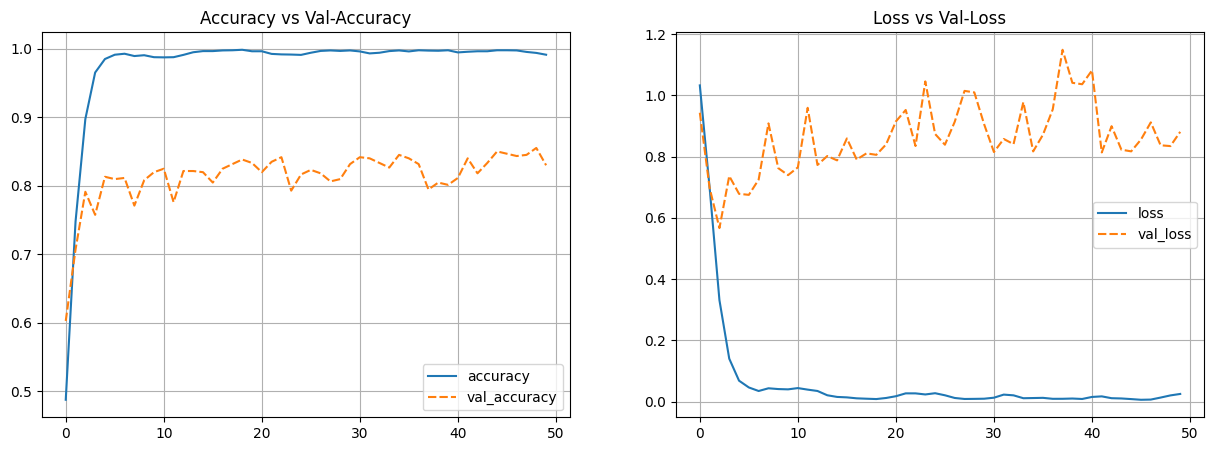

In [ ]:
plot_result(model_tuned_hist)

This model has smaller difference than the previous one but still overfits

## Tuned Model 2

In [ ]:
# model tuned 2
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model_tuned = Sequential()

model_tuned.add(text_vectorization)
model_tuned.add(embedding)
model_tuned.add(Bidirectional(LSTM(32, return_sequences=True,
                                   dropout=0.2, recurrent_dropout=0.1,
                                   kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                   )))
model_tuned.add(Dropout(0.2))
model_tuned.add(Bidirectional(LSTM(32,
                                   dropout=0.2, recurrent_dropout=0.1,
                                   kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                   )))
model_tuned.add(Dropout(0.2))
model_tuned.add(Dense(3, activation='softmax'))


model_tuned.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           833024    
                                                                 
 bidirectional (Bidirection  (None, 32, 64)            41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                        

- Dropout for output is increased to 0.2 since the model still overfits
- Dropout for input is applied in both hidden layer to help with a more strict regularizations
- recurrent_dropout helps prevent overfitting across the sequence itself.
- Adding more neurons on the 2nd hidden layer since a lot of regularizations are added. This makes the LSTM focus on the most important aspects of the data.

In [ ]:
model_tuned_hist = model_tuned.fit(
    X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe)
    )

Epoch 1/50
130/130 [==============================] - 47s 194ms/step - loss: 1.0947 - accuracy: 0.3791 - val_loss: 1.0203 - val_accuracy: 0.5202
Epoch 2/50
130/130 [==============================] - 29s 222ms/step - loss: 0.9831 - accuracy: 0.5201 - val_loss: 0.8656 - val_accuracy: 0.6061
Epoch 3/50
130/130 [==============================] - 33s 252ms/step - loss: 0.8371 - accuracy: 0.6245 - val_loss: 0.7296 - val_accuracy: 0.6818
Epoch 4/50
130/130 [==============================] - 26s 198ms/step - loss: 0.7019 - accuracy: 0.6994 - val_loss: 0.6542 - val_accuracy: 0.7239
Epoch 5/50
130/130 [==============================] - 26s 201ms/step - loss: 0.5721 - accuracy: 0.7670 - val_loss: 0.5981 - val_accuracy: 0.7508
Epoch 6/50
130/130 [==============================] - 29s 226ms/step - loss: 0.5124 - accuracy: 0.7945 - val_loss: 0.5225 - val_accuracy: 0.8030
Epoch 7/50
130/130 [==============================] - 34s 265ms/step - loss: 0.4484 - accuracy: 0.8325 - val_loss: 0.5418 - val_ac

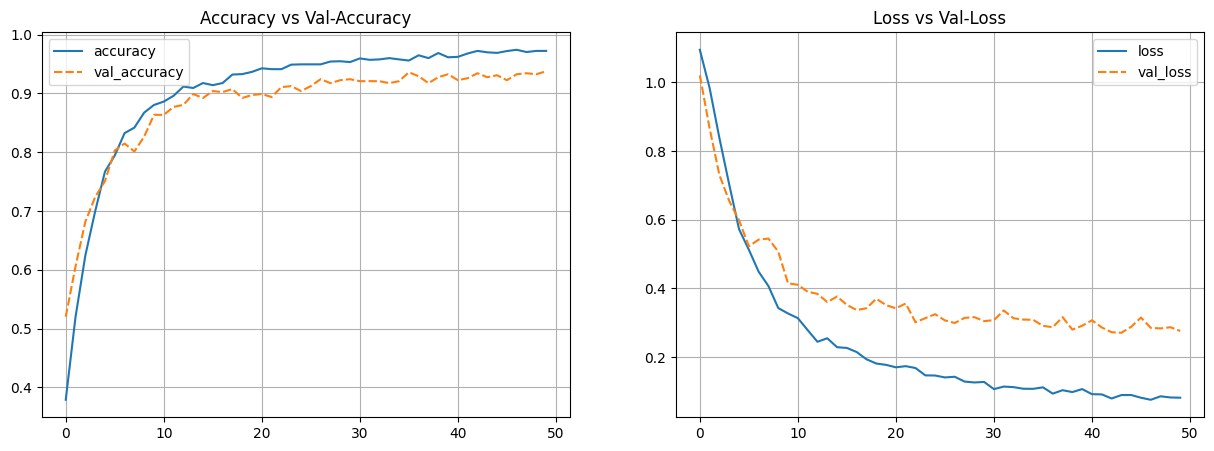

In [ ]:
plot_result(model_tuned_hist)

The loss has quite the gap but with the accuracy only having 5% difference, this model is considered a good fit

## Using Callbacks and Regulations

In [ ]:
callbacks1= [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint('model_checkpoint.tf', monitor='val_loss',save_best_only=True)
]

Callback and checkpoint is used to get make machine learning more efficient and effective. Efficient in a way that it will stop learning the moment the the monitor parameter is triggered, indicating that it's not improving significantly which can reduce the time to run the machine learning. Model Checkpoints helps saving the best model depending on the monitor parameter.

In [ ]:
# model tuned 3

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model_tuned = Sequential()

model_tuned.add(text_vectorization)
model_tuned.add(embedding)
model_tuned.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.1),
                                   dropout=0.1,
                                   kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                   )))
model_tuned.add(Dropout(0.1))
model_tuned.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.1),
                                   dropout=0.1,
                                   kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                   )))
model_tuned.add(Dropout(0.1))
model_tuned.add(Dense(3, activation='softmax'))


model_tuned.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 32)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 32, 128)           833024    
                                                                 
 bidirectional (Bidirection  (None, 32, 64)            41216     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                        

- Trying to decrease dropout and appy regularization L2 to prevent overfitting in machine learning models by penalizing large weights

In [ ]:
model_tuned_hist = model_tuned.fit(
    X_train, y_train_ohe, epochs=50, validation_data=(X_val, y_val_ohe),
    callbacks=callbacks1
    )

Epoch 1/50
130/130 [==============================] - 18s 91ms/step - loss: 15.5399 - accuracy: 0.9102 - val_loss: 2.9795 - val_accuracy: 0.8670
Epoch 2/50
130/130 [==============================] - 3s 25ms/step - loss: 0.7744 - accuracy: 0.9949 - val_loss: 1.0053 - val_accuracy: 0.8384
Epoch 3/50
130/130 [==============================] - 4s 29ms/step - loss: 0.1457 - accuracy: 0.9892 - val_loss: 0.6599 - val_accuracy: 0.8788
Epoch 4/50
130/130 [==============================] - 3s 25ms/step - loss: 0.1803 - accuracy: 0.9829 - val_loss: 0.7642 - val_accuracy: 0.8434
Epoch 5/50
130/130 [==============================] - 2s 16ms/step - loss: 0.1098 - accuracy: 0.9959 - val_loss: 0.8052 - val_accuracy: 0.8569
Epoch 6/50
130/130 [==============================] - 2s 14ms/step - loss: 0.0461 - accuracy: 0.9983 - val_loss: 0.7779 - val_accuracy: 0.8636
Epoch 7/50
130/130 [==============================] - 2s 16ms/step - loss: 0.0338 - accuracy: 0.9947 - val_loss: 0.8727 - val_accuracy: 0.85

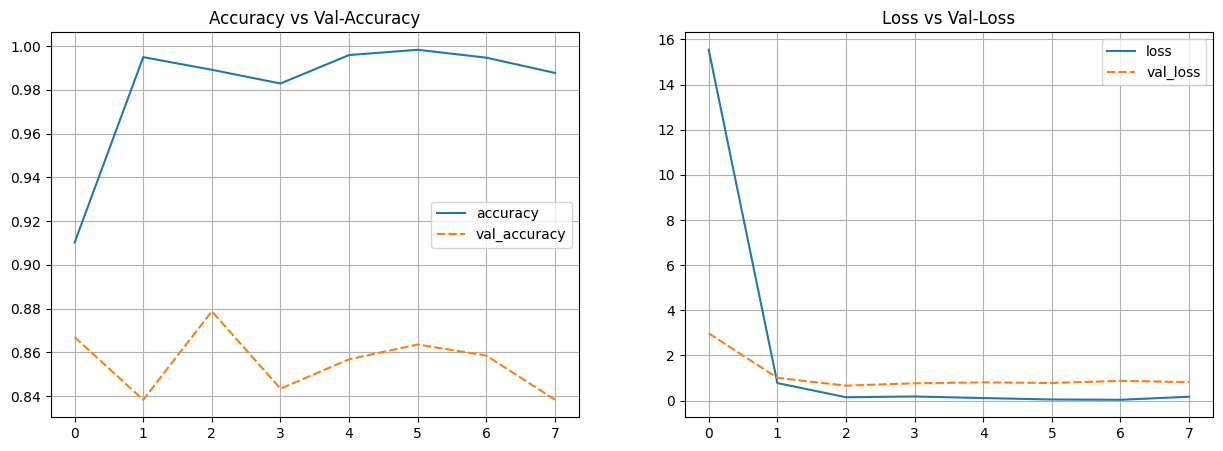

In [ ]:
plot_result(model_tuned_hist)

Regularization was tried since it could help with overfitting, in this case it didn't help and the previous model is still better

# Model Evaluation

| Models         | Accuracy | Val Accuracy | Performance |
|----------------|----------|--------------|-------------|
| RNN            | 99.8%    | 78.4%        | Fast        |
| LSTM tuned 1   | 99.1%    | 83%          | Long        |
| **LSTM tuned 2**   | **97.2%**    |**94%**         | Longest     |
| LSTM tuned 3   | 98.8%    | 83.3%        | Long        |

The best model is LSTM tuned 2 with good fit result. LSTM tuned 2 is a model that has higher units(neurons) to capture more complex patterns and has higher dropout values to minimize overfitting.

In [ ]:
# tuned model 2
model = load_model('best_model.keras')

Test - Set
38/38 [==============================] - 2s 34ms/step


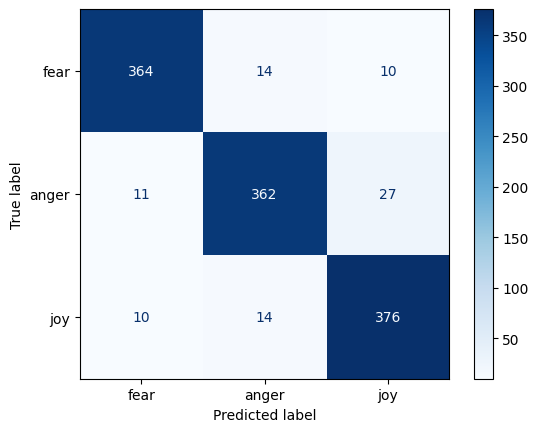

              precision    recall  f1-score   support

        fear       0.95      0.94      0.94       388
       anger       0.93      0.91      0.92       400
         joy       0.91      0.94      0.92       400

    accuracy                           0.93      1188
   macro avg       0.93      0.93      0.93      1188
weighted avg       0.93      0.93      0.93      1188



In [ ]:
# result
print('Test - Set')
performance_check(model, X_test, y_test_ohe)

The confusion matrix and classification report shows that the model is doing a good job of predicting emotions overall. However, it's not as good at recognizing joy because it sometimes gets mixed up with anger. This might be happening because words used to describe anger are also being used when people talk about joy.

In [ ]:
df[(df['Emotion'] == 'joy') | (df['Emotion'] == 'anger')][['Emotion','preprocessed_text']].sample(15)

,Emotion,preprocessed_text
2298,anger,meet subtly obnoxious annoying universe
2908,joy,excited ton catching
940,joy,pleased pgce qualified teacher work make effor...
1482,anger,spent last half hour ridiculously angry insens...
5500,anger,came freaked brink tear angry confused ridicul...
580,anger,still annoyed older sd always sick something m...
2717,joy,much optimistic coming en route
251,anger,pretty cranky morning stopping made lot better
1116,joy,content alive motivated
927,anger,even go subject interesting anyway relating pe...


In [ ]:
joy_dict = dict(joy_word_freq.most_common(30))
anger_dict = dict(anger_word_freq.most_common(30))

common_words = set(joy_dict.keys()) & set(anger_dict.keys())
common_words_counts = {word: (joy_dict[word], anger_dict[word]) for word in common_words}

print(' joy - anger')
display(common_words_counts)

 joy - anger


{'dont': (54, 66),
 'think': (67, 74),
 'thing': (56, 73),
 'go': (43, 53),
 'could': (61, 72),
 'back': (50, 58),
 'one': (76, 81),
 'day': (91, 72),
 'even': (71, 87),
 'life': (76, 69),
 'still': (60, 64),
 'would': (65, 84),
 'something': (76, 60),
 'way': (72, 85),
 'need': (61, 58)}

The descriptive data shows that there are still words that becomes noise or is unsignificant that can lead to the misclassfication. Suggestion for future would be to intensify text processing part.  A more significant and less noise data would lead to a more accurate result

# Saving Functions

In [ ]:
dump(stop_words_en, 'stopword_list.joblib')
model_tuned.save('best_model.keras') # model tuned 2

['stopword_list.joblib']

# Conclusion

The dataset is well maintained and has a balance target class. EDA shows that most people are quite concise when it comes to expressing their feelings, only a few whom can write really long and be more open about what they feel. Life, good, day, something, going and well are words that are most often expressed when people describe a joyful experience. Would, even, way, think, and angry are words that's the most often expressed when a person is mad. Still, bit, strange, ank think are words that is most often expressed when a person describing a fearful experience. Anger and fear are a special case. Anger words such as 'would' and 'even' is an auxillary verb that indicates a mood or tense. Fear is a broad emotion where it can classify into fear of the unknown that involes anxiety and fear as if being scared or teriffied, giving goosebumps. The best model uses LSTM network with 93% accuracy. There still seems to be a lot of noise therefor, focusing on preprocessing such as adding more stopwords could help the model learn patterns more accurately in the future. The dataset currently includes just three emotions, but incorporating data on a wider range of emotions would enhance the model's ability to classify more diverse emotional states.